# Shade my Run
## Dataset creation

- [LIDAR Data](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1537)


From [Summary](https://daac.ornl.gov/CMS/guides/CMS_LiDAR_AGB_California.html):

"This dataset provides estimates of aboveground biomass and spatially explicit uncertainty from 53 airborne LiDAR surveys of locations throughout California between 2005 and 2014. Aboveground biomass was estimated by performing individual tree crown detection and applying a customized "remote sensing aware" allometric equation to these individual trees. Aboveground biomass estimates and their uncertainties for each study area are provided in per-tree and gridded format. The canopy height models used for the tree detection and biomass estimation are also provided.
There are 9,504 files in compressed shapefile format (*.shp contained in *.zip) and 212 files in GeoTIFF format (*.tif) included in this dataset."


In [1]:
# import packages
from map_retrieve import mapRetrieve
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import os
from pprint import pprint
from glob import glob
from PIL import Image
import numpy as np

# create the mapRetrieve object
mr = mapRetrieve(log=True)



### Shape files

Each tree is represented by a polygon object which a set of coordinates.   One popular package for dealing with shapes is pyshp.  In addition the files are zipped so we used python's ZipFile library to open the folder in memory without wirting all the files to disk. We use pycrs to extract the projection information we need to align the shape file with other maps. 

In [2]:
f_name = os.path.join('data','sample_set', 'Bagley2013_41063N_12211324W.zip')
shape, proj4, epsg = mr.load_shape(f_name)

INFO:root:
Getting epsg from https://spatialreference.org/ref/epsg/nad83-utm-zone-10n/
INFO:root:Got EPSG:26910
INFO:root:
Proj4 string decoded:
 +proj=utm +datum=NAD83 +ellps=GRS80 +a=6378137.0 +rf=298.257222101 +pm=0 +lat_0=0.0 +lon_0=-123.0 +x_0=500000.0 +y_0=0.0 +units=m +axis=enu +no_defs


### Get Bounding Box of shape file

We use the pyproj tools to project the shape bounding box from UTM to geo coordinates, and rerrange the bounding box for the GDAL command later.  


In [3]:
extents, utm_extents = mr.get_bounds(shape, proj4)


INFO:root:
Projected extents:
 [-122.1134080383651, 41.06290067842876, -122.10037557540628, 41.050248611294634]


### Get a World Imagery map with the extents of the shape file 

We first request a map from the arcgis World Imagery map server. Note this uses call a GDAL program as a sytem process so it is not purely python. 


INFO:root:
stdout:
 Input file size is 33554432, 16777216
0...10...20...30...40...50...60...70...80...90...100 - done.

INFO:root:
The process returned with code: 0


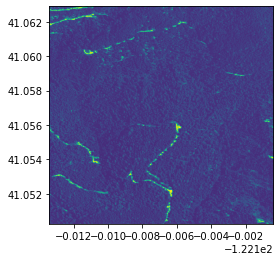

In [4]:
dst_file = 'maps/test_clip.tif'
mr.get_map(extents, dst_file)

with rasterio.open(dst_file) as src:
    show(src)

### Warp Map to match projection of LIDAR data

Next we need to transform the map to match the match the LIDAR data. Again we use a GDAL program as a system process. 

INFO:root:
stdout:
 Creating output file that is 1055P x 1345L.
Processing maps/test_clip.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.

INFO:root:
The process returned with code: 0


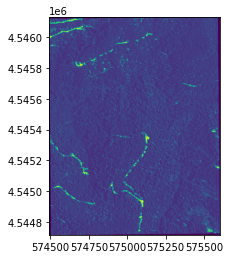

In [5]:
r_dst_file = 'maps/test_clip_r.tif'
mr.warp_map(src_file=dst_file, dst_file=r_dst_file, epsg=epsg)
with rasterio.open(r_dst_file) as src:
    show(src)


INFO:root:
stdout:
 Input file size is 1055, 1345
0...10...20...30...40...50...60...70...80...90...100 - done.

INFO:root:
The process returned with code: 0


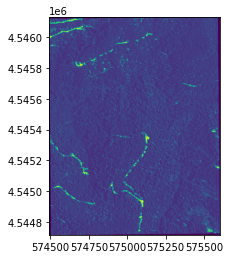

In [6]:
png_dst_file = 'maps/test_clip.png'
mr.png_map(r_dst_file, png_dst_file)
with rasterio.open(png_dst_file) as src:
    show(src)


### Plotting with rasterio 

Here we visualize the polygons and corresponding bounding box from the shape file and overlay onto the rasterio transfromed map

In [ ]:

f = plt.figure()

for poly in shape.shapeRecords():
    # plot the original polygons
    x1 = [p[0] for p in poly.shape.points]
    y1 = [p[1] for p in poly.shape.points]
    #plt.plot(x1,y1)
    # plot the polygon bounding boxes
    minx, miny, maxx, maxy = poly.shape.bbox
    x2 = [minx, minx, maxx, maxx, minx]
    y2 = [miny, maxy, maxy, miny, miny]
    plt.plot(x2,y2)

# plot the reprojected map
src = rasterio.open(png_dst_file)
show(src.read(), transform=src.transform)

plt.show()

### Plotting the png results

Here we visualize the map and corresponding bounding boxes after converting to png and saving the json labels. 

* note that we only keep trees over 30 ft when we save the labels so there are a lot less boxes

In [ ]:
mr.png_print(png_dst_file = 'maps/Bagley2013_41063N_12211324W.png',
             label_file = 'labels/Bagley2013_41063N_12211324W.js')

### Finally we save the bounding box data as a json file. 

In [8]:
src = rasterio.open(png_dst_file)

mr.shape_to_voc(png_dst_file, shape, src.transform, f_name='labels/test.xml')
# mr.save_json(json_file, dst_file='labels/test.js')

with open('labels/test.xml', 'r') as f:
    head = [next(f) for x in range(10)]
pprint(head)



INFO:root:
image shape: (1345, 1055, 3)
['<annotation>\n',
 '    <folder>maps</folder>\n',
 '    <filename>test_clip.png</filename>\n',
 '    '
 '<path>c:\\Users\\crm0376\\Projects\\ShadeMyRun\\maps\\test_clip.png</path>\n',
 '    <source>\n',
 '        <database>Unknown</database>\n',
 '    </source>\n',
 '    <size>\n',
 '        <width>1055</width>\n',
 '        <height>1345</height>\n']


### Putting it all together 

Now we can just feed in the name of a zip file and save a map image and a corresponding json file with the boudnng boxws labeled. 

In [ ]:

# get the names of all the zip files in the data folder
#zip_files = glob(os.path.join('data','sample_set','*.zip'))
from glob import glob
from map_retrieve import mapRetrieve

def run_data_creation():
    zip_files = glob("/media/zac/Seagate Portable Drive/orders/f06d9ed2c630d7ad6ecfd53ecda4d412/CMS_LiDAR_AGB_California/data/*.zip")
    print("Got zip files:")
    print(zip_files)
    mr = mapRetrieve(log=False, label_folder="roboflow_data", out_folder="roboflow_data")
    # for each zip file run the save_map method
    print("Initialized MapRetrieve")
    file_counter = 0
    max_count = 1
    zip_files.sort()
    for index, zf in enumerate(zip_files):
        if file_counter < max_count and index % 19 == 0:
            print(f'{file_counter} - Converting {zf} ...')
            mr.save_map(zf)
            file_counter = file_counter + 1
        elif file_counter >= max_count:
            print(file_counter)
            print(max_count)
            break
        print("Lcv:" + str(index))

run_data_creation()

In [2]:
# cleaning up
import os
try:
    [os.remove(f) for f in glob(os.path.join('labels','*'))]
    os.rmdir('labels')
except:
    pass
try:
    [os.remove(f) for f in glob(os.path.join('maps','*'))]
    os.rmdir('maps')
except:
    pass
